In [1]:
from datetime import datetime
from MetaTrader5 import *
MT5Initialize()
MT5WaitForTerminal()

print(MT5TerminalInfo())
print(MT5Version())

[2, 'MetaQuotes-Demo', '21592194']
[500, 2233, '28 Nov 2019']


In [2]:
rates = MT5CopyRatesRange("EURUSD", MT5_TIMEFRAME_D1, datetime(2000,1,1), datetime(2019,11,28))

In [3]:
import pandas as pd
d = pd.DataFrame(list(rates),
                           columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume'])

In [4]:
d['median']=(d['high']+d['low'])/2
d['delta'] = d['high'].diff(1).fillna(0)

In [5]:
d

,time,open,high,low,close,tick_volume,spread,real_volume,median,delta
0,2000-01-03,1.00730,1.02780,1.00540,1.02460,6642,50,0,1.016600,0.00000
1,2000-01-04,1.02430,1.03400,1.02130,1.02920,7339,50,0,1.027650,0.00620
2,2000-01-05,1.02930,1.04020,1.02840,1.03260,6570,50,0,1.034300,0.00620
3,2000-01-06,1.03250,1.04150,1.02720,1.03300,7223,50,0,1.034350,0.00130
4,2000-01-07,1.03290,1.03320,1.02600,1.02980,5689,50,0,1.029600,-0.00830
...,...,...,...,...,...,...,...,...,...,...
5171,2019-11-21,1.10723,1.10969,1.10521,1.10581,31829,1,0,1.107450,0.00156
5172,2019-11-22,1.10580,1.10875,1.10144,1.10182,32645,1,0,1.105095,-0.00094
5173,2019-11-25,1.10151,1.10320,1.10035,1.10126,27995,1,0,1.101775,-0.00555
5174,2019-11-26,1.10129,1.10255,1.10072,1.10194,28638,1,0,1.101635,-0.00065


<IPython.core.display.Javascript object>


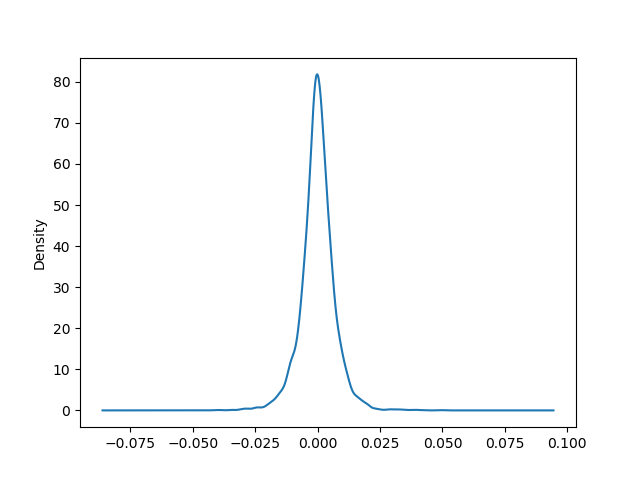

In [6]:
%matplotlib nbagg
d['delta'].plot.kde()

Мы получили распределение Коши. Дальше этот факт будет учитываться.

In [7]:
ln=d['delta'].values
import numpy as np
as_strided = np.lib.stride_tricks.as_strided
win = 5
v = as_strided(ln, (len(d) - (win - 1), win), (ln.strides * 2))
wn=pd.DataFrame(v,columns=['d1','d2','d3','d4','d5'])
wn

,d1,d2,d3,d4,d5
0,0.00000,0.00620,0.00620,0.00130,-0.00830
1,0.00620,0.00620,0.00130,-0.00830,-0.00270
2,0.00620,0.00130,-0.00830,-0.00270,0.00360
3,0.00130,-0.00830,-0.00270,0.00360,0.00290
4,-0.00830,-0.00270,0.00360,0.00290,-0.00540
...,...,...,...,...,...
5167,0.00294,0.00332,-0.00061,-0.00025,0.00156
5168,0.00332,-0.00061,-0.00025,0.00156,-0.00094
5169,-0.00061,-0.00025,0.00156,-0.00094,-0.00555
5170,-0.00025,0.00156,-0.00094,-0.00555,-0.00065


In [8]:
from scipy.stats import spearmanr
coef, p = spearmanr(wn['d1'], wn['d2'])
print('кореляция ',coef)
print('p-value ',p)

кореляция  0.11172226388792181
p-value  7.756388462012735e-16


Определение параметров распределения.

In [9]:
from stats import *

In [10]:
model=cauchyvar(d['delta'])
with model:
    trace = pm.sample(2000, tune=1000, step=pm.NUTS(), chains=1, init='nuts')

Sequential sampling (1 chains in 1 job)
NUTS: [beta, alfa]
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:12<00:00, 237.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [11]:
print(pm.summary(trace))

          mean        sd  mc_error   hpd_2.5  hpd_97.5
alfa  0.000048  0.000066  0.000001 -0.000079  0.000178
beta  0.003163  0.000058  0.000001  0.003056  0.003278


<IPython.core.display.Javascript object>


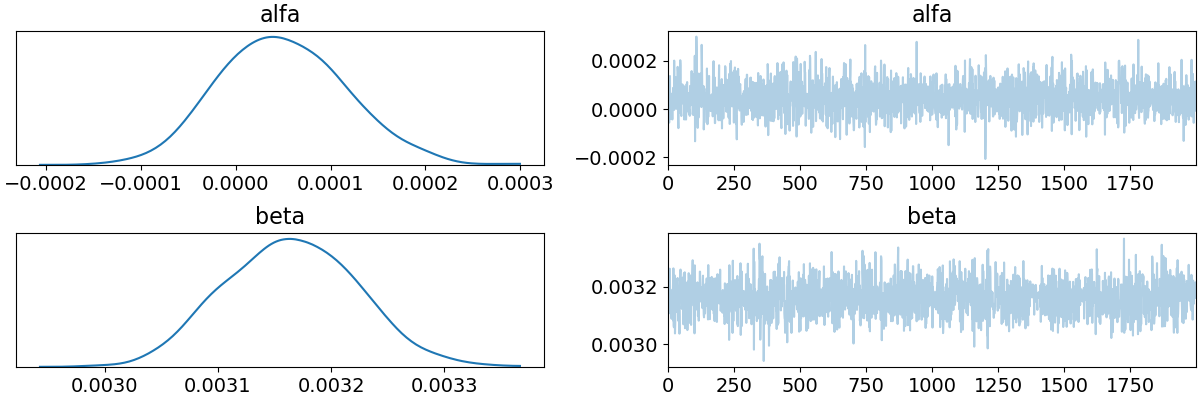

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C2AB8EC688>,
      dtype=object)

In [12]:
pm.traceplot(trace)

Все горорят о изменчевости рынка. Давайте проверим изменчив ли наш ряд приращений

In [13]:
d1=d['delta'].iloc[:1725]
d2=d['delta'].iloc[1725:2*1725]
d3=d['delta'].iloc[2*1725:]

In [14]:
model1=cauchyvar(d1)
with model:
    trace1 = pm.sample(2000, tune=1000, step=pm.NUTS(), chains=1, init='nuts')
model2=cauchyvar(d2)
with model:
    trace2 = pm.sample(2000, tune=1000, step=pm.NUTS(), chains=1, init='nuts')
model3=cauchyvar(d3)
with model:
    trace3 = pm.sample(2000, tune=1000, step=pm.NUTS(), chains=1, init='nuts')

Sequential sampling (1 chains in 1 job)
NUTS: [beta, alfa]
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:12<00:00, 243.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alfa]
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:11<00:00, 253.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alfa]
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:13<00:00, 222.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [15]:
print(pm.summary(trace1))
print(pm.summary(trace2))
print(pm.summary(trace3))

          mean        sd  mc_error  hpd_2.5  hpd_97.5
alfa  0.000050  0.000068  0.000002 -0.00009  0.000181
beta  0.003163  0.000059  0.000001  0.00304  0.003268
          mean        sd  mc_error   hpd_2.5  hpd_97.5
alfa  0.000044  0.000069  0.000002 -0.000086  0.000175
beta  0.003163  0.000057  0.000001  0.003053  0.003268
          mean        sd  mc_error   hpd_2.5  hpd_97.5
alfa  0.000046  0.000066  0.000002 -0.000072  0.000191
beta  0.003161  0.000059  0.000001  0.003035  0.003264


Изменение очень незначительные. Их практически нет. Можно считать что вероятно и дальше  их не будет раз небыло за 10 лет